### Importing relevant libraries

In [28]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Importing dataset

In [2]:
df = pd.read_csv("alldata.csv")

In [3]:
df = df.drop("Unnamed: 7", axis = 1)

In [4]:
df = df.drop(1042, axis = 0)

In [5]:
df["ZeroCross"] = df["ZERO CROSS OVER"].copy()
df = df.drop("ZERO CROSS OVER", axis =1)
df["SignalCross"] = df["SIGNAL LINE CROSSOVER"].copy()
df = df.drop("SIGNAL LINE CROSSOVER", axis = 1)
df["macdDecision"] = df["Decision"].copy()
df = df.drop("Decision", axis = 1)

### Transforming hammer variable: 0= no hammer, 1 = hammer

In [6]:
df["Hammer"] = df["Hammer"].replace("HAMMER", 1)
df["Hammer"] = df["Hammer"].fillna(0)

### Transforming Support and Resistance: support = resistance = 1 ; other = 0

In [7]:
def supportResistanceEncoding(df):
    df["Support"] = df["Support"].fillna(0)
    df["Resistance"] = df["Resistance"].fillna(0)
    df.loc[df.Support == "S", "Support"] = 1
    df.loc[df.Resistance == "R", "Resistance"] = 1

supportResistanceEncoding(df)


### Transforming Zero cross over and signal Line Crossover: sell = 0, buy = 1

In [8]:
def crossoverEncoding(df):
    df.loc[df.ZeroCross == "Buy", "ZeroCross"] = 1
    df.loc[df.SignalCross == "Buy", "SignalCross"] = 1
    df.loc[df.ZeroCross == "Sell", "ZeroCross"] = 0
    df.loc[df.SignalCross == "Sell", "SignalCross"] = 0
    
crossoverEncoding(df)

In [9]:
#dropping this column since it is not common practice to base a decision only on the two crossovers
df = df.drop("macdDecision", axis = 1)

### Finding perfect buy/sell/hold entries 
#### looking at future values, we will determine if at each entry, the best option would have been to buy/sell/hold based on the return on the investment (%)

In [10]:
# plot = go.Figure(data = [go.Candlestick(x = df["Date"],
#                                        open = df["Open"],
#                                        high = df["High"],
#                                        low = df["Low"],
#                                        close = df["Close"])])
# plot.show()

In [26]:
# Assume zero trading cost
# 0 = hold, 1 = buy, 2 = sell
# Rule: compare today's closing and +timeframe day's closing
# We omit the first 13 days since williams%Rs are unavailable, decision value = -1
# We omit the last day since the next day closing is unavailable, decision value = -1

def perfectEntries_2(df, timeframe):
    decision = [-1 for i in range(13)]  # for the first 13 days
    currentdecision = 0

    for i in range(13, (len(df) - 1 - timeframe)):  # from 14th day to the day before the last day
        if df.iloc[i+timeframe]['Close'] > df.iloc[i]['Close']:
            if currentdecision != 1:
                currentdecision = 1
            else:
                currentdecision = 0
            decision.append(currentdecision)
            currentdecision = 1  # Make sure if next day is buy, we show it hold
        elif df.iloc[i+timeframe]['Close'] < df.iloc[i]['Close']:
            # The first sell cannot appear before buy or hold
            if decision.count(1) > 0:
                if currentdecision != 2:
                    currentdecision = 2
                else:
                    currentdecision = 0
                decision.append(currentdecision)
                currentdecision = 2  # Make sure if next day is sell, we show it hold
            else:
                currentdecision = 0
                decision.append(currentdecision)
        else:
            currentdecision = 0
            decision.append(currentdecision)
    for i in range(timeframe+1):
        decision.append(-1)  # for the last days

    return decision

len(perfectEntries_2(df,2))

1042

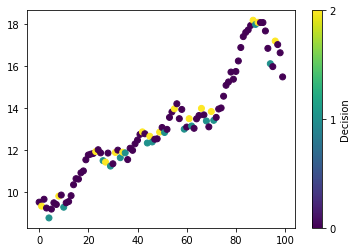

In [54]:
df['Decision'] = perfectEntries_2(df,2)
plt.scatter(range(100), df["Close"][100:200], c=df["Decision"][100:200])
plt.colorbar(ticks = range(3), label='Decision')
# looking at two days in advance seems like the better solution, 1 sometimes miss opportunities and higher(7 and 14 were tried) 
# and it gives weird signals 

In [13]:
# Convert willianR values to 0 = neutral, 1 = overbought, 2 = oversold
# The first 13 days are excluded, gives zero value automatically

def williamsREncoding(df):

    williamsR = [0 for i in range(13)]

    for i in range(13, len(df)):

        if df.iloc[i]['WilliamR'] < -0.2 and df.iloc[i]['WilliamR'] > -0.8:
            williamsR.append(0)
        elif df.iloc[i]['WilliamR'] >= -0.2:
            williamsR.append(1)
        else:
            williamsR.append(2)
    
    return williamsR

df.insert(11, 'Williams%R', williamsREncoding(df))
df

,Date,Close,Var. (%),Open,Low,High,Volume,Support,Resistance,Hammer,WilliamR,Williams%R,12EMA,26 EMA,MACD LINE,SIGNAL LINE,HISTOGRAM,ZeroCross,SignalCross,Decision
0,2016-01-26,4.20,-4.76,4.23,4.12,4.31,"302,717,532",0,0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-1
1,2016-01-27,4.57,8.81,4.22,4.16,4.64,"352,368,579",0,0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-1
2,2016-01-28,4.60,0.66,4.67,4.35,5.13,"618,332,894",0,0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-1
3,2016-01-29,4.84,5.22,4.70,4.52,4.86,"439,826,229",0,0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-1
4,2016-02-01,4.72,-2.48,4.74,4.66,4.86,"245,882,432",0,0,0.0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,2020-04-03,15.34,-1.10%,16.30,14.93,16.36,"142,01M",0,0,0.0,-0.212281,0,14.571038,16.868583,-2.297545,-3.066222,0.768677,0,1,1
1038,2020-04-06,15.77,2.80%,16.05,15.18,16.10,"122,54M",0,0,0.0,-0.136842,1,14.755494,16.787207,-2.031713,-2.859320,0.827607,0,1,0
1039,2020-04-07,16.40,3.99%,16.61,16.34,17.07,"139,72M",0,0,0.0,-0.107717,1,15.008495,16.758525,-1.750030,-2.637462,0.887432,0,1,0
1040,2020-04-08,17.32,5.61%,16.50,16.40,17.53,"114,58M",0,0,0.0,-0.033600,1,15.364111,16.800116,-1.436005,-2.397171,0.961166,0,1,2


In [14]:
# df.to_csv('cleaned_data.csv')